# Using and Understanding Docling for Targeted Geofenced Extraction on Documents

In [1]:
# Uncomment to install the required packages
# !pip install docling_core
# !pip install thefuzz

## The `document_to_extraction.py` script

This is designed as a .py script to be run in CLI, not as a notebook. If you want to run it, copy the code out of this and create a .py file.

IMPORTANT NOTE--This has the Docling package internal DEBUG settings for vizualizing OCR/Table/Layout etc. image creation active, which is highlight commented in the .py code. If you want to vizualize the outputs for the documts, it will dump those images into a `./debug/` folder in `cwd`. If you're running this on a lot of documents, that folder can blow up in disk space. ***CAREFUL***

### Basic Usage
`python document_to_extraction.py INPUT_DIRECTORY [--output_dir OUTPUT_DIRECTORY] [--log-level LEVEL]`

### Required Arguments

`INPUT_DIRECTORY`: The directory containing your documents to process

- Supports files with extensions: .pdf, .png, .jpg, .jpeg, .tiff, .tif
- This argument is mandatory and must be provided

### Optional Arguments
#### Output Directory

`--output_dir OUTPUT_DIRECTORY`

Specifies where processed files will be saved. Defaults to "scratch/" if not provided. The directory will be created if it doesn't exist. For each input file, creates three output files:

- `{filename}.md`: Markdown version
- `{filename}.json`: JSON format
- `{filename}.yaml`: YAML format

#### Logging Level

`--log-level LEVEL`

Controls the verbosity of logging output
Available options: DEBUG, INFO, WARNING, ERROR
Defaults to "INFO" if not specified
Use DEBUG for maximum detail during troubleshooting

#### Example Commands
Process files in the "documents" folder using default settings:
- `python document_to_extraction.py documents`

Process files with custom output location:
- `python document_to_extraction.py documents --output_dir processed_files`

Process files with detailed debug logging:
- `python document_to_extraction.py documents --log-level DEBUG`

```python
import argparse
import json
import logging
from pathlib import Path
from typing import List

import yaml
from docling.datamodel.settings import settings
from docling.document_converter import (
    DocumentConverter,
)

_log = logging.getLogger(__name__)

# Turn on inline debug visualizations:
settings.debug.visualize_layout = True
settings.debug.visualize_ocr = True
settings.debug.visualize_tables = True
settings.debug.visualize_cells = True


def get_input_files(input_dir: Path) -> List[Path]:
    """Get all PDF and image files from the input directory."""
    supported_extensions = {".pdf", ".png", ".jpg", ".jpeg", ".tiff", ".tif"}
    return [
        Path(f) for f in input_dir.iterdir() if f.suffix.lower() in supported_extensions
    ]


def main(input_dir, output_dir):
    doc_converter = DocumentConverter()
    conv_results = doc_converter.convert_all(get_input_files(input_dir))

    for res in conv_results:
        out_path = output_dir
        print(
            f"Document {res.input.file.name} converted."
            f"\nSaved markdown output to: {str(out_path)}"
        )
        _log.debug(res.document._export_to_indented_text(max_text_len=16))
        
        # Export Docling document:
        with (out_path / f"{res.input.file.stem}.md").open("w") as fp:
            fp.write(res.document.export_to_markdown())

        with (out_path / f"{res.input.file.stem}.json").open("w") as fp:
            fp.write(json.dumps(res.document.export_to_dict()))

        with (out_path / f"{res.input.file.stem}.yaml").open("w") as fp:
            fp.write(yaml.safe_dump(res.document.export_to_dict()))


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Process documents with Docling")
    parser.add_argument(
        "input_dir", type=str, help="Input directory containing documents"
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="scratch/",
        help="Output directory for processed files (default: scratch/)",
    )
    parser.add_argument(
        "--log-level",
        type=str,
        default="INFO",
        choices=["DEBUG", "INFO", "WARNING", "ERROR"],
        help="Set the logging level",
    )

    args = parser.parse_args()

    logging.basicConfig(
        level=getattr(logging, args.log_level),
        format="%(asctime)s - %(levelname)s - %(message)s",
    )
    input_dir = Path(args.input_dir)
    output_dir = Path(args.output_dir)

    if not input_dir.exists():
        raise ValueError(f"Input directory does not exist: {input_dir}")

    output_dir.mkdir(parents=True, exist_ok=True)

    main(input_dir, output_dir)
```

## Examing the Docling Document Object and How to Use it

In [20]:
from docling_core.types.doc import DoclingDocument
import copy
import json
from pathlib import Path
from pprint import pprint
from thefuzz import fuzz
from IPython.display import display
import requests
from PIL import Image
from io import BytesIO
from PIL import ImageDraw

**I pulled this image from Google Images for testing, but I'm not sure if the information is actually true or not, so I redacted what might be personal info, not sure**

In [3]:
# Load saved docling doc from disk:
url = "https://raw.githubusercontent.com/JoeHelbing/OCR-VLM-Embedding-Comprehensive-Testing/master/docling/scratch/large.json"
response = requests.get(url)
doc_dict = response.json()
doc = DoclingDocument.model_validate(doc_dict)

**Let's see the actual image of the form**

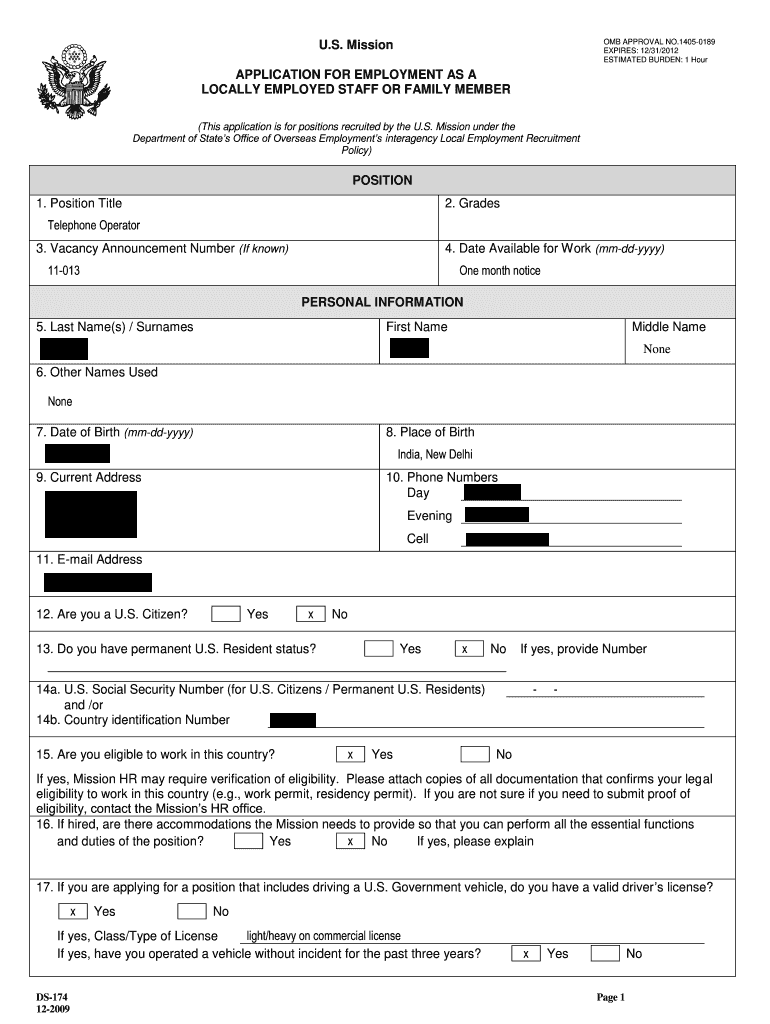

In [4]:
# Load image from URL
url = "https://raw.githubusercontent.com/JoeHelbing/OCR-VLM-Embedding-Comprehensive-Testing/master/data/forms/large.png"
response = requests.get(url)
img = response.content
img = Image.open(BytesIO(img))

# Display image
display(img)

**This is an example of the OCR output from Docling**

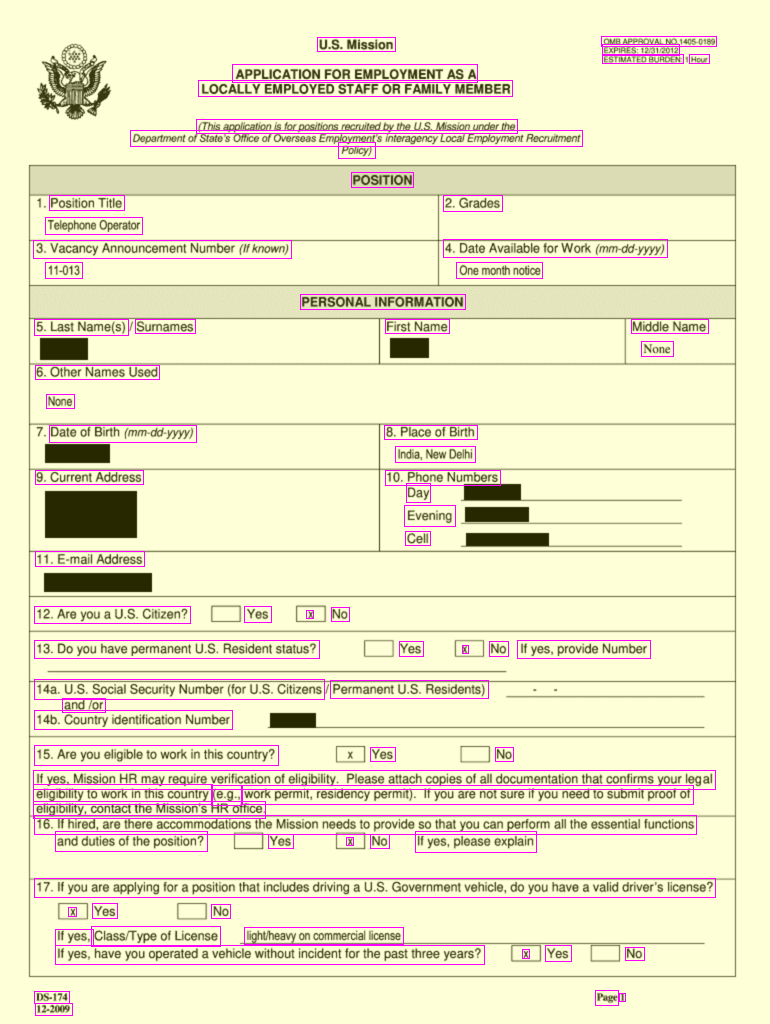

In [5]:
# Load image from URL
url = "https://raw.githubusercontent.com/JoeHelbing/OCR-VLM-Embedding-Comprehensive-Testing/315d2b6946b86321ea5e4ab81de8a9698d18c470/docling/debug/debug_large/ocr_page_00000.png"
response = requests.get(url)
ocr_img_path = response.content
# Display image
display(Image.open(BytesIO(ocr_img_path)))

## Docling Document Object in it's Entirety

### The major parts of a Docling Document object
[Docling Document Documentation](https://ds4sd.github.io/docling/reference/docling_document/)
- body
- furniture
- groups
- key_value_items
- name
- origin
- pages
- pictures
- schema_name
- tables
- texts
- version

Major Sections of Docling Document Object

In [6]:
for k in doc.dict().keys():
    print(k)

schema_name
version
name
origin
furniture
body
groups
texts
pictures
tables
key_value_items
pages


Some expansion of the non-text elements.

In [7]:
for k, v in doc.dict().items():
    if k not in ["body", "groups", "texts", "pictures", "tables"]:
        print(f"{k}: {v}")


schema_name: DoclingDocument
version: 1.0.0
name: large
origin: {'mimetype': 'application/pdf', 'binary_hash': 17442536969041507999, 'filename': 'large.png', 'uri': None}
furniture: {'self_ref': '#/furniture', 'parent': None, 'children': [], 'name': '_root_', 'label': <GroupLabel.UNSPECIFIED: 'unspecified'>}
key_value_items: []
pages: {1: {'size': {'width': 770.0, 'height': 1024.0}, 'image': None, 'page_no': 1}}


### Docling Text Examples

Below is a small selection of the text section of a docling document object.

In [8]:
# Docling document oject doc.texts type
print("What datatype is doc.texts?")
print(type(doc.texts))
print()
print("What datatype is doc.texts[0]?")
print(type(doc.texts[0]))
print()
print("What do some examples of doc.texts look like?")
for text in doc.texts[:5]:
    pprint(text)
print()
# Lets expand the first text object as a heiarchical dictionary
print("What does doc_dict['texts'][0] look like?")
pprint(doc_dict["texts"][0])

What datatype is doc.texts?
<class 'list'>

What datatype is doc.texts[0]?
<class 'docling_core.types.doc.document.ListItem'>

What do some examples of doc.texts look like?
ListItem(self_ref='#/texts/0', parent=RefItem(cref='#/groups/0'), children=[], label=<DocItemLabel.LIST_ITEM: 'list_item'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=36.17273712158203, t=828.3333129882812, r=124.0, b=813.6666870117188, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 14))], orig='Position Title', text='Position Title', enumerated=False, marker='-')
ListItem(self_ref='#/texts/1', parent=RefItem(cref='#/groups/0'), children=[], label=<DocItemLabel.LIST_ITEM: 'list_item'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=443.3333435058594, t=829.0, r=502.3333435058594, b=812.3333129882812, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 9))], orig='2. Grades', text='2. Grades', enumerated=False, marker='-')
TextItem(self_ref='#/texts/2', parent=RefItem(cr

### Docling Text Object Examples and Explanations

So a single example of the actual `Docling.text[0]` object looks like...

```python
ListItem(self_ref='#/texts/0', parent=RefItem(cref='#/groups/0'), children=[], label=<DocItemLabel.LIST_ITEM: 'list_item'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=36.17273712158203, t=828.3333129882812, r=124.0, b=813.6666870117188, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 14))], orig='Position Title', text='Position Title', enumerated=False, marker='-')
```

Which, to make it a bit easier to understand via a hiearchical pprint of a dictionary structure ```doc_dict["texts"][0]``` looks like...
```JSON
{'children': [],
 'enumerated': False,
 'label': 'list_item',
 'marker': '-',
 'orig': 'Position Title',
 'parent': {'$ref': '#/groups/0'},
 'prov': [{'bbox': {'b': 813.6666870117188,
                    'coord_origin': 'BOTTOMLEFT',
                    'l': 36.17273712158203,
                    'r': 124.0,
                    't': 828.3333129882812},
           'charspan': [0, 14],
           'page_no': 1}],
 'self_ref': '#/texts/0',
 'text': 'Position Title'}
 ```

As far as I've seen, prov is a list that is always len() == 1, so we can just use [0] to get the first element, which encodes all the information needed to get the bounding information.

For non-text items, this might get more complicated, but at least for this use case, it seems to work. The items for a 

#### Now that we know what a docling document object looks like, how do we use it?
Let's try and find a section of the document we would want to extract if this was some standardized form. For example, let's look for "Position Title" and examine that response object. Well do a fuzzy string search across the strings in doc.texts, which we know to be a list of Text objects. We can access the text of those text objects via `doc.texts[i].text`.

In [9]:
# use a list comprehension to find the text 'Position Title' with a fuzzy match in doc.texts.
THRESHOLD = 80  # Fuzzy match threshold, higher is more strict
found_text = [
    text
    for text in doc.texts
    if fuzz.partial_ratio("Position Title", text.text) > THRESHOLD
]
print(f"Found {len(found_text)} matches")
print("==========The Found Text==========")
pprint(found_text[0].text)
print()
print("==========The Found Text Object Heiarchicah JSON==========")
pprint(found_text[0].dict())
print()
print("==========The Found Text Object Bounding Boxes==========")
pprint(found_text[0].prov[0].bbox.dict())

Found 1 matches
==========The Found Text==========
'Position Title'

==========The Found Text Object Heiarchicah JSON==========
{'children': [],
 'enumerated': False,
 'label': <DocItemLabel.LIST_ITEM: 'list_item'>,
 'marker': '-',
 'orig': 'Position Title',
 'parent': {'cref': '#/groups/0'},
 'prov': [{'bbox': {'b': 813.6666870117188,
                    'coord_origin': <CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>,
                    'l': 36.17273712158203,
                    'r': 124.0,
                    't': 828.3333129882812},
           'charspan': (0, 14),
           'page_no': 1}],
 'self_ref': '#/texts/0',
 'text': 'Position Title'}

==========The Found Text Object Bounding Boxes==========
{'b': 813.6666870117188,
 'coord_origin': <CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>,
 'l': 36.17273712158203,
 'r': 124.0,
 't': 828.3333129882812}


#### We found the text of interest that defines our form entry, now what?
We searched across `doc.texts[i].text` and found an object that matches our search string, and that has attached to it the metadata we are going to use to construct a geofenced based extraction system.

The `doc.texts[i].prov` contains a list of provenance objects, which include page numbers and bounding box information. We access that information via `doc.texts[i].prov[0].bbox` to get the coordinates of the bounding box via the attributes `bbox.b, bbox.l, bbox.r, bbox.t`.

Below is just some abstraction functions to pull out repeated processes in refining the extraction process, explained in code comments per function.

In [40]:
# Let's pull out some repeated functions in this process
def find_text_bbox(search_text, doc):
    "Function that takes in some search text, searches the doc.texts for a match and returns the text object"
    THRESHOLD = 80
    found_text = [
        text
        for text in doc.texts
        if fuzz.partial_ratio(search_text, text.text) > THRESHOLD
    ]
    if not found_text:
        return None
    return found_text


def found_text_debug(found_text, img_height, img_width):
    "Function that takes in a text object, and some image metadata and prints out some debug information"
    print(f"Found {len(found_text)} matches")
    print("==========The Found Text==========")
    pprint(found_text[0].text)
    print()
    print("==========The Found Text Object Heiarchicah JSON==========")
    pprint(found_text[0].model_dump())
    print()
    print("==========The Found Text Object Bounding Boxes==========")
    pprint(f"Image Height: {img_height}")
    pprint(f"Image Width: {img_width}")
    pprint(found_text[0].prov[0].bbox.model_dump())


def crop_and_resize(
    img, left, top, right, bottom, img_height, img_width, target_width=400
):
    """
    Function to take in a PIL image, crop it and resize it based on
    the bounding box coordinates and image metadata
    """
    # Crop image using converted coordinates
    cropped_img = img.crop((left, top, right, bottom))

    # Calculate new height maintaining aspect ratio
    target_width = target_width
    width_percent = target_width / float(cropped_img.size[0])
    target_height = int((float(cropped_img.size[1]) * float(width_percent)))

    # Resize image
    resized_img = cropped_img.resize(
        (target_width, target_height), Image.Resampling.LANCZOS
    )
    return resized_img


def show_drawn_boxes(bbox, search_bbox, right_adjust, bottom_adjust, img):
    """
    Function to visualize the found text, the expanded bounding box, and the searched area
    """
    img_height = img.height
    img_width = img.width

    # Create combined found text and searching area bounding box
    cbbox = BoundingBox(
        l=min(bbox.l, search_bbox.l),
        t=min(bbox.t, search_bbox.t),
        r=max(bbox.r, search_bbox.r),
        b=max(bbox.b, search_bbox.b),
        origin=CoordOrigin.TOPLEFT,
    )

    # Draw the combined area as a pink box, the found text bbox in red, and the searching area in green
    draw = ImageDraw.Draw(img)
    draw.rectangle([cbbox.l, cbbox.t, cbbox.r, cbbox.b], outline="pink", width=2)
    draw.rectangle([bbox.l, bbox.t, bbox.r, bbox.b], outline="red", width=2)
    draw.rectangle(
        [search_bbox.l, search_bbox.t, search_bbox.r, search_bbox.b],
        outline="green",
        width=2,
    )
    expanded_image = crop_and_resize(
        img,
        cbbox.l - 10,
        bbox.t - 10,
        cbbox.r + 10,
        cbbox.b + 10,
        img_height,
        img_width,
        target_width=800,
    )
    return expanded_image


### Weird Issue I don't fully understand yet with Coordinate System
The default for Docling coordinate system is TOPLEFT, which is what alost everything else uses, but the file output this time was bottom left. The BoundingBox class has a conversion ability as a method within it, so this function below creates a copy of the document class and converts everything to TOPLEFT coordinate system from BOTTOMLEFT. I don't know why this happened and I can't find the reason in the documentation. If this happens to you, this code will convert EVERYTHING in the Docling Document Class to TOPLEFT coordinate system.

In [11]:
def flip_doc_y_axis(doc):
    # Create a deep copy to avoid modifying the original
    alt_doc = copy.deepcopy(doc)

    def convert_provs(item, page_heights):
        """Helper to convert all provenances for an item"""
        if hasattr(item, "prov"):
            for prov in item.prov:
                page_height = page_heights.get(prov.page_no)
                if page_height is not None:
                    prov.bbox = prov.bbox.to_top_left_origin(page_height)

    # Get all page heights once
    page_heights = {
        page_no: page.size.height for page_no, page in alt_doc.pages.items()
    }

    # Convert coordinates in all document elements
    for text in alt_doc.texts:
        convert_provs(text, page_heights)

    for picture in alt_doc.pictures:
        convert_provs(picture, page_heights)

    for table in alt_doc.tables:
        convert_provs(table, page_heights)
        # Also convert table cell bounding boxes
        for cell in table.data.table_cells:
            if cell.bbox is not None:
                # Use the table's first provenance page height for cells
                if len(table.prov) > 0:
                    page_height = page_heights.get(table.prov[0].page_no)
                    if page_height is not None:
                        cell.bbox = cell.bbox.to_top_left_origin(page_height)

    for group in alt_doc.groups:
        convert_provs(group, page_heights)

    return alt_doc


# Runs the function to flip the document
flip_doc = flip_doc_y_axis(doc)

In [21]:
def crop_and_display(search_text, doc, img):
    """Function to visualize bounding boxes of found text via cropped image"""
    found_text = find_text_bbox(search_text, doc)
    img_height = img.height
    img_width = img.width
    found_text_debug(found_text, img_height, img_width)

    # Get bounding box from first match
    bbox = found_text[0].prov[0].bbox

    resized_img = crop_and_resize(
        img, bbox.l, bbox.t, bbox.r, bbox.b, img_height, img_width
    )

    return resized_img

Found 1 matches
==========The Found Text==========
'Position Title'

==========The Found Text Object Heiarchicah JSON==========
{'children': [],
 'enumerated': False,
 'label': <DocItemLabel.LIST_ITEM: 'list_item'>,
 'marker': '-',
 'orig': 'Position Title',
 'parent': {'cref': '#/groups/0'},
 'prov': [{'bbox': {'b': 210.33331298828125,
                    'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>,
                    'l': 36.17273712158203,
                    'r': 124.0,
                    't': 195.66668701171875},
           'charspan': (0, 14),
           'page_no': 1}],
 'self_ref': '#/texts/0',
 'text': 'Position Title'}

==========The Found Text Object Bounding Boxes==========
'Image Height: 1024'
'Image Width: 770'
{'b': 210.33331298828125,
 'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>,
 'l': 36.17273712158203,
 'r': 124.0,
 't': 195.66668701171875}


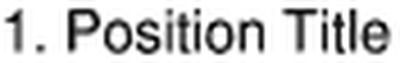

In [22]:
# Display the resized image
display(crop_and_display("Position Title", flip_doc, img))

Found 1 matches
==========The Found Text==========
'If yes, Class Type of License'

==========The Found Text Object Heiarchicah JSON==========
{'children': [],
 'label': <DocItemLabel.TEXT: 'text'>,
 'orig': 'If yes, Class Type of License',
 'parent': {'cref': '#/body'},
 'prov': [{'bbox': {'b': 946.6666641235352,
                    'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>,
                    'l': 55.33333206176758,
                    'r': 220.0,
                    't': 926.3333358764648},
           'charspan': (0, 29),
           'page_no': 1}],
 'self_ref': '#/texts/44',
 'text': 'If yes, Class Type of License'}

==========The Found Text Object Bounding Boxes==========
'Image Height: 1024'
'Image Width: 770'
{'b': 946.6666641235352,
 'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>,
 'l': 55.33333206176758,
 'r': 220.0,
 't': 926.3333358764648}


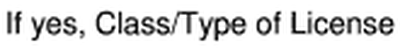

In [23]:
display(crop_and_display("If yes Class/Type of License", flip_doc, img))

## Why is this Useful?
In the context of a form, we can use the fuzzy-match search strings across a wide array of different image sizes and form types to localize form responses assuming the form itself is standardized.

System Setup Needs:
- Identify the items you need to extract from a form
- Do some reading and experimentation on finding the strings that are associated with the form box you need to extract info from
- For example--Let's say we want to extract the Position Title everyone applied for in 10,000 documents.
- The "Position Title" applied for is below the string "Position Title"
- We need to crop the text from the document based on position information.

Let's iteratively construct the bounding box to get that info.

In [24]:
from docling_core.types.doc import BoundingBox, CoordOrigin

In [25]:
def crop_and_display_position_title(
    search_text, doc, img, right_adjust=100, bottom_adjust=35
):
    """
    Function to visualize the altered bounding box of found text and pixel adjustments
    returning a cropped and resized image using the found text bounding box plus adjustments
    """
    # Now we adjust the bounding box to include below the found text
    found_text = find_text_bbox(search_text, doc)
    img_height = img.height
    img_width = img.width

    # Get bounding box from first match
    bbox = found_text[0].prov[0].bbox

    # Create a bounding box incorporating the right and bottom adjustments
    cbbox = BoundingBox(
        l=bbox.l,
        t=bbox.b,
        r=bbox.r + right_adjust,
        b=bbox.b + bottom_adjust,
        origin=CoordOrigin.TOPLEFT,
    )

    # Crop the image using that altered bounding box and resize the image so it looks good
    resized_img = crop_and_resize(
        img, cbbox.l, cbbox.t, cbbox.r, cbbox.b, img_height, img_width
    )
    return resized_img

### Iteratively constructing the bounding box
This is trail and error for each section of a document you need to extract. You try something and see if the resulting image has the text within it you need. This is done using pixel values, so you adjust the edges of the bounding box to encapsulate the text you need. I find it helpful to start by widening the bounding box of the original seached text when I first do this so that you can keep some context of what you're looking at, but this function goes straight for creating the bounding box for the text you want to extract. This function only adjusts right, and bottom points, but you could alter that to fit whatever needs you have for your extraction needs.

```python
    # Create a bounding box incorporating the right and bottom adjustments
    cbbox = BoundingBox(
        l=bbox.l,
        t=bbox.b, # <- Top of bbox for text you want to extract is bottom of bbox for text you found (may be different in your usecase)
        r=bbox.r + right_adjust, # add a right adjust to extend that bbox past the original found text
        b=bbox.b + bottom_adjust, # add a bottom adjust to extend that bbox below the original found text
        origin=CoordOrigin.TOPLEFT,
    )
```

Start with a guess that seems reasonable, and work from there. I'm starting with 100 pixels expansion to the right of the found text, and 100 pixels expansion below the found text.

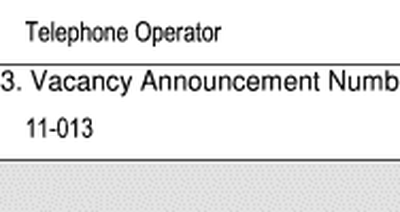

In [30]:
# right adjust looks decent, bottom adjust is too much, we iterate to find the best value
display(
    crop_and_display_position_title(
        "Position Title", flip_doc, img, right_adjust=100, bottom_adjust=100
    )
)

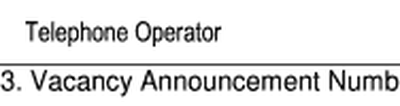

In [31]:
# Still no good, we try a smaller bottom adjust
display(
    crop_and_display_position_title(
        "Position Title", flip_doc, img, right_adjust=100, bottom_adjust=50
    )
)

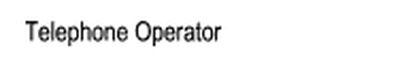

In [32]:
# Perfection
display(
    crop_and_display_position_title(
        "Position Title", flip_doc, img, right_adjust=100, bottom_adjust=30
    )
)

We found the correct bounding box, it's a right adjust `100` and a bottom adjust `30` for this form item.

## So We Have a Bounding Box that Encapsulates a Form Response We Want, Now what?
We need that response, and that response only, so let's pull only the text that is below our searched text, but above the bottom and right side of our bounding box.

In [38]:
"""Function to visualize bounding boxes of found text overlayed on cropped image"""


def crop_and_display_position_title_return_response_text(
    search_text, doc, img_path, right_adjust=100, bottom_adjust=35
):
    # Now we adjust the bounding box to include below the found text
    found_text = find_text_bbox(search_text, doc)

    # Image metadata
    img_height = img.height
    img_width = img.width

    # Get bounding box from first match
    bbox = found_text[0].prov[0].bbox

    # Cut the bounding box of the found text from the total bounding box area
    # This is to get the text below the found text
    search_bbox = BoundingBox(
        l=bbox.l,
        t=bbox.b,
        r=bbox.r + right_adjust,
        b=bbox.b + bottom_adjust,
        origin=CoordOrigin.TOPLEFT,
    )

    # Call explanatory visualizations
    explanatory_viz = show_drawn_boxes(
        bbox, search_bbox, right_adjust, bottom_adjust, img
    )

    print("Searched bbox coordinates")
    print(search_bbox)

    # Pull the text from the document that fits within the adapted rt_bounding_box
    # We only check if the prov is same page as searched text to limit search space
    # List comprehension for speed
    response_text = [
        text
        for text in doc.texts
        if (
            found_text[0].prov[0].page_no == text.prov[0].page_no
            and text.prov[0].bbox.l >= search_bbox.l
            and text.prov[0].bbox.r <= search_bbox.r
            and text.prov[0].bbox.t >= search_bbox.t
            and text.prov[0].bbox.b <= search_bbox.b
        )
    ]

    return explanatory_viz, response_text


Searched bbox coordinates
l=36.17273712158203 t=210.33331298828125 r=224.0 b=240.33331298828125 coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>


    The searched text that defines the form entry is shown in the red box.
    The desired extraction text search area is shown in green.
    The combined area of search and found text in pink.
    


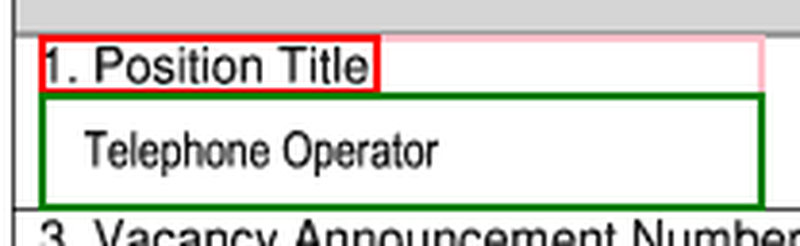

======= Found Text ======
'Telephone Operator'


In [45]:
rt_image, rt_text = crop_and_display_position_title_return_response_text(
    "Position Title", flip_doc, img, right_adjust=100, bottom_adjust=30
)
print()
print("""
    The searched text that defines the form entry is shown in the red box.
    The desired extraction text search area is shown in green.
    The combined area of search and found text in pink.
    """)
display(rt_image)
print("======= Found Text ======")
for text in rt_text:
    pprint(text.text)

## Success!
We found the text we needed based of a geolocaton of the form box title text, and were able to make a dynamically adjusted text extraction of the form box entry "Telephone Operator" as a string. Now all we have to do is pipe this process into some storage system that tracks the extraction from each document with it's associated meta-data. This would be a job for a SQL database, but we'll leave that for a different day.